# 📈 Notebook 01 — S&P 500 Data Collection & Exploratory Data Analysis (EDA)

**Goal:**  
Load S&P 500 historical data, clean it, resample to monthly/quarterly, and conduct initial exploratory analysis to identify potential features for time-series modeling.

This notebook supports the FOMC Sentiment & S&P 500 Time-Series Analysis project.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

In [6]:
# Download S&P 500 index from FRED
sp500 = pdr.DataReader("SP500", "fred", start="2000-01-01", end="2025-01-01")

# Rename column to match our project convention
sp500 = sp500.rename(columns={"SP500": "sp500"})

sp500.head()

,sp500
DATE,
2015-11-13,2023.04
2015-11-16,2053.19
2015-11-17,2050.44
2015-11-18,2083.58
2015-11-19,2081.24


In [8]:
# Convert FRED's daily data to month-end frequency
sp500_m = sp500.resample("M").last()

# Show sample
sp500_m.head()

/var/folders/7_/j79tjdv53zb0k6zvj6gbbc8r0000gn/T/ipykernel_25934/2806372139.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sp500_m = sp500.resample("M").last()


,sp500
DATE,
2015-11-30,2080.41
2015-12-31,2043.94
2016-01-31,1940.24
2016-02-29,1932.23
2016-03-31,2059.74


In [9]:
sp500.to_csv("../data/sp500_raw.csv")
print("Saved raw SP500 data to ../data/sp500_raw.csv")

Saved raw SP500 data to ../data/sp500_raw.csv


<Axes: title={'center': 'Monthly S&P 500 (FRED)'}, xlabel='DATE'>

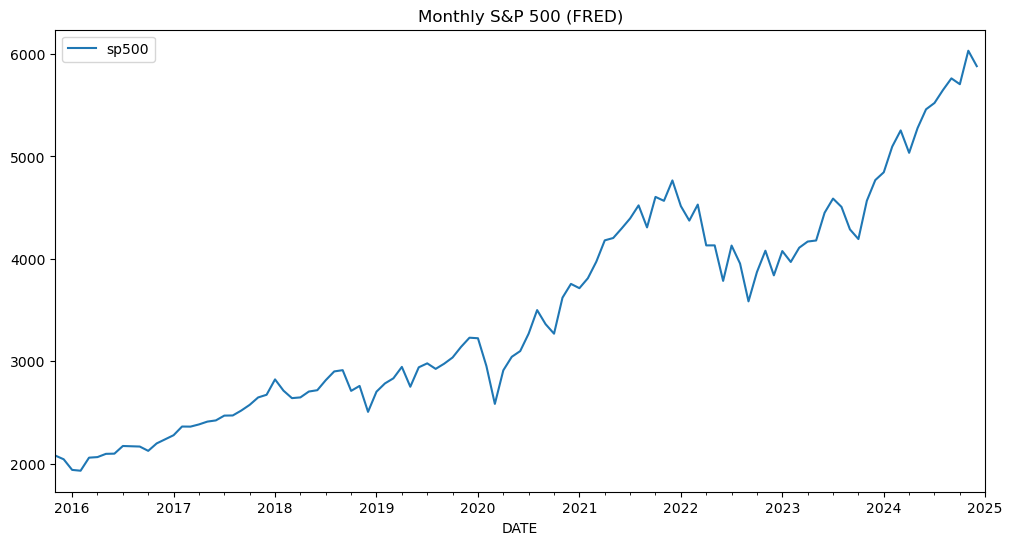

In [10]:
sp500_m.plot(figsize=(12,6), title="Monthly S&P 500 (FRED)")

### SP500 feature creation:
We engineered a comprehensive set of monthly S&P 500 features to support exploratory analysis and future predictive modeling. Core features include 1-month returns, next-month forward returns (our prediction target), and first differences, which capture short-term price behavior. We added rolling 3-month and 6-month volatility measures to quantify market risk leading into each period. To standardize comparisons across time, we computed z-scores for returns and volatility, allowing us to evaluate how extreme a given month is relative to long-run history. Finally, we categorized each monthly return into one of five regimes—high negative, negative, flat, positive, and high positive—and created one-hot indicator columns for each regime. These categories help simplify return dynamics into interpretable states, enabling easier visualization, descriptive statistics, and downstream modeling aligned with macroeconomic events such as FOMC meetings.


In [16]:
# Target: next month's return (shifted backward)
sp500_m["ret_1m"] = sp500_m["sp500"].pct_change()
sp500_m["ret_1m_next"] = sp500_m["ret_1m"].shift(-1)
sp500_m["firstdiff_1m"] = sp500_m["sp500"].diff()
sp500_m["vol_3m"] = sp500_m["ret_1m"].rolling(3).std()
sp500_m["vol_6m"] = sp500_m["ret_1m"].rolling(6).std()
sp500_m.head(12)

/var/folders/7_/j79tjdv53zb0k6zvj6gbbc8r0000gn/T/ipykernel_25934/1182639902.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sp500_m["ret_1m"] = sp500_m["sp500"].pct_change()


,sp500,ret_1m,ret_1m_next,firstdiff_1m,vol_3m,vol_6m
DATE,,,,,,
2015-11-30,2080.41,NaN,-0.017530,NaN,NaN,NaN
2015-12-31,2043.94,-0.017530,-0.050735,-36.47,NaN,NaN
2016-01-31,1940.24,-0.050735,-0.004128,-103.70,NaN,NaN
2016-02-29,1932.23,-0.004128,0.065991,-8.01,0.023994,NaN
2016-03-31,2059.74,0.065991,0.002699,127.51,0.058757,NaN
2016-04-30,2065.30,0.002699,0.015329,5.56,0.038664,NaN
2016-05-31,2096.96,0.015329,0.000906,31.66,0.033496,0.038660
2016-06-30,2098.86,0.000906,0.035610,1.90,0.007861,0.037519
2016-07-31,2173.60,0.035610,-0.001219,74.74,0.017434,0.026924


In [18]:
# Helper function
def zscore(series):
    return (series - series.mean()) / series.std()

# Z-scores for returns
sp500_m["ret_1m_z"] = zscore(sp500_m["ret_1m"])
sp500_m["ret_1m_next_z"] = zscore(sp500_m["ret_1m_next"])

# Z-scores for volatility
sp500_m["vol_3m_z"] = zscore(sp500_m["vol_3m"])
sp500_m["vol_6m_z"] = zscore(sp500_m["vol_6m"])


One hot encoding returns categorization: possible prediction/regression targets

In [41]:
# ---- Return Categorization (One-Hot Encoding, aligned with ret_regime) ----

r = sp500_m["ret_1m"]

# thresholds based on volatility
ret_std = r.std()
flat_thr = 0.001        # ±0.1% is "flat"
strong_thr = ret_std    # 1 standard deviation move

# Initialize category columns to 0
for col in [
    "ret_high_negative",
    "ret_negative",
    "ret_flat",
    "ret_positive",
    "ret_high_positive"
]:
    sp500_m[col] = 0

# Assign categories with the SAME logic as ret_regime
sp500_m.loc[r < -strong_thr,                            "ret_high_negative"] = 1
sp500_m.loc[(r >= -strong_thr) & (r < -flat_thr),       "ret_negative"]       = 1
sp500_m.loc[(r >= -flat_thr) & (r <= flat_thr),         "ret_flat"]           = 1
sp500_m.loc[(r > flat_thr) & (r <= strong_thr),         "ret_positive"]       = 1
sp500_m.loc[r > strong_thr,                             "ret_high_positive"]  = 1


Same data being used for regression here instead of classification

In [38]:
r = sp500_m["ret_1m"]
ret_std = r.std()

flat_thr = 0.005          # ±0.1% is considered "flat"
strong_thr = ret_std      # 1 standard deviation move

sp500_m["ret_regime"] = np.select(
    condlist=[
        r < -strong_thr,                            # High Negative
        (r >= -strong_thr) & (r < -flat_thr),       # Negative
        (r >= -flat_thr) & (r <= flat_thr),         # Flat
        (r > flat_thr) & (r <= strong_thr),         # Positive
        r > strong_thr                              # High Positive
    ],
    choicelist=[-2, -1, 0, 1, 2],
    default=np.nan
)


In [42]:
# Sanity Check
category_cols = [
    "ret_high_negative",
    "ret_negative",
    "ret_flat",
    "ret_positive",
    "ret_high_positive"
]

# Sum the one-hot rows
sp500_m["category_sum"] = sp500_m[category_cols].sum(axis=1)

sp500_m["category_sum"].value_counts().head()


category_sum
1    110
0      1
Name: count, dtype: int64

In [43]:
sp500_m["ret_regime"].value_counts().sort_index()


ret_regime
-2.0    13
-1.0    17
 0.0    15
 1.0    45
 2.0    20
Name: count, dtype: int64

In [44]:
# ---- Export S&P 500 monthly features to data/ ----

output_path = "../data/sp500_features.csv"

sp500_m.to_csv(output_path, index=True)

output_path


'../data/sp500_features.csv'

### Why We Add GDP and Interest Rate Data  
To properly evaluate whether FOMC statement sentiment helps explain or predict S&P 500 returns, we need to control for broader macroeconomic conditions. Market movements are influenced not only by central bank communication, but also by fundamental drivers such as economic growth and monetary policy. By incorporating Real GDP (a proxy for economic activity) and the Federal Funds Rate (a direct measure of monetary policy stance), we can separate the effect of the FOMC statement itself from simultaneous macroeconomic changes. Including these variables ensures that any observed relationship between statement sentiment and market behavior is not simply reflecting underlying GDP trends or interest rate shifts, but instead captures the unique informational impact of the communication.


In [46]:

# ---- Download GDP (Quarterly) ----
gdp = pdr.DataReader("GDPC1", "fred", start="1990-01-01", end="2025-01-01")
gdp = gdp.rename(columns={"GDPC1": "gdp_real"})

# Convert quarterly GDP → monthly (forward-fill is standard)
gdp = gdp.resample("M").ffill()

print(gdp.head())

# ---- Fed Funds Rate ----
fedfunds = pdr.DataReader("FEDFUNDS", "fred", start="1990-01-01", end="2025-01-01")
fedfunds = fedfunds.rename(columns={"FEDFUNDS": "fed_funds_rate"})

print(fedfunds.head())


             gdp_real
DATE                 
1990-01-31  10047.386
1990-02-28  10047.386
1990-03-31  10047.386
1990-04-30  10083.855
1990-05-31  10083.855
            fed_funds_rate
DATE                      
1990-01-01            8.23
1990-02-01            8.24
1990-03-01            8.28
1990-04-01            8.26
1990-05-01            8.18


/var/folders/7_/j79tjdv53zb0k6zvj6gbbc8r0000gn/T/ipykernel_25934/2877837560.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gdp = gdp.resample("M").ffill()


In [47]:
gdp["gdp_mom"] = gdp["gdp_real"].pct_change()
fedfunds["ff_mom"] = fedfunds["fed_funds_rate"].diff()
fedfunds["ff_mom_pct"] = fedfunds["fed_funds_rate"].pct_change()

Initial EDA

In [48]:
# ---- Merge macro data into sp500_m ----

sp500_macro = (
    sp500_m
    .merge(gdp[["gdp_real", "gdp_mom"]], left_index=True, right_index=True, how="left")
    .merge(fedfunds[["fed_funds_rate", "ff_mom", "ff_mom_pct"]], left_index=True, right_index=True, how="left")
)

sp500_macro.head()


,sp500,ret_1m,ret_1m_next,firstdiff_1m,vol_3m,vol_6m,ret_1m_z,ret_1m_next_z,vol_3m_z,vol_6m_z,...,ret_flat,ret_positive,ret_high_positive,category_sum,ret_regime,gdp_real,gdp_mom,fed_funds_rate,ff_mom,ff_mom_pct
DATE,,,,,,,,,,,,,,,,,,,,,
2015-11-30,2080.41,NaN,-0.017530,NaN,NaN,NaN,NaN,-0.629309,NaN,NaN,...,0,0,0,0,NaN,18892.206,0.000000,NaN,NaN,NaN
2015-12-31,2043.94,-0.017530,-0.050735,-36.47,NaN,NaN,-0.629309,-1.375342,NaN,NaN,...,0,0,0,1,-1.0,18892.206,0.000000,NaN,NaN,NaN
2016-01-31,1940.24,-0.050735,-0.004128,-103.70,NaN,NaN,-1.375342,-0.328205,NaN,NaN,...,0,0,0,1,-2.0,19001.690,0.005795,NaN,NaN,NaN
2016-02-29,1932.23,-0.004128,0.065991,-8.01,0.023994,NaN,-0.328205,1.247195,-0.552712,NaN,...,0,0,0,1,0.0,19001.690,0.000000,NaN,NaN,NaN
2016-03-31,2059.74,0.065991,0.002699,127.51,0.058757,NaN,1.247195,-0.174804,0.716062,NaN,...,0,0,1,1,2.0,19001.690,0.000000,NaN,NaN,NaN


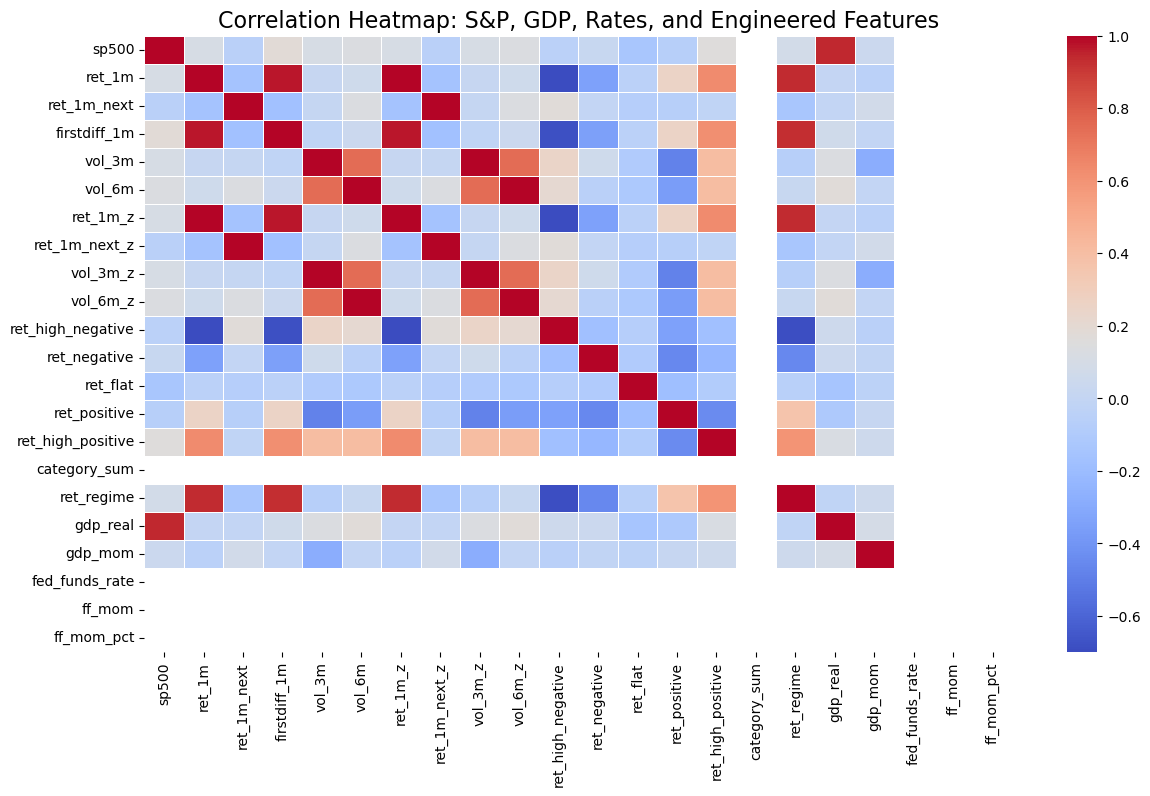

In [49]:
sp500_macro = sp500_macro.dropna(subset=["ret_1m", "ret_1m_next"])

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))
sns.heatmap(
    sp500_macro.corr(),
    cmap="coolwarm",
    annot=False,
    linewidths=0.5
)

plt.title("Correlation Heatmap: S&P, GDP, Rates, and Engineered Features", fontsize=16)
plt.show()


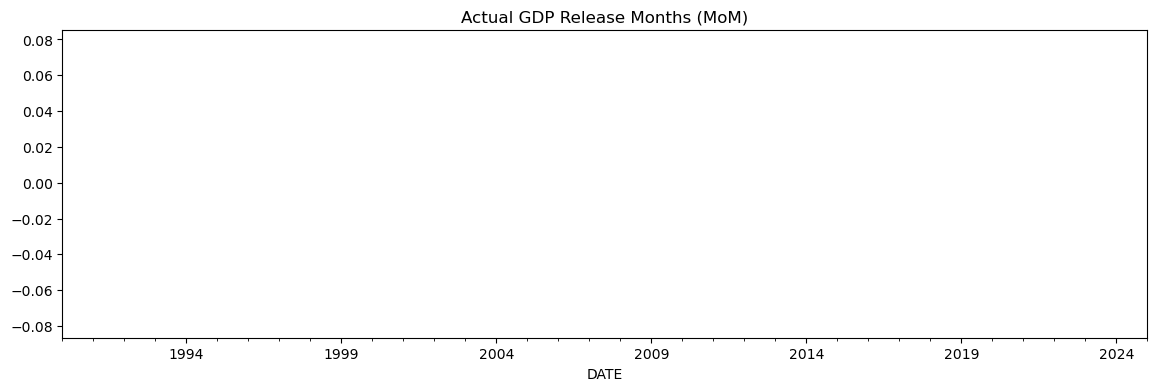

In [53]:
# Replace artificial zero values with NaN
gdp["gdp_mom_clean"] = gdp["gdp_mom"].replace(0, pd.NA)

gdp["gdp_mom_clean"] = gdp["gdp_real"].diff().replace(0, pd.NA)
# convert to pct change 
gdp["gdp_mom_clean"] = gdp["gdp_mom_clean"] / gdp["gdp_real"].shift(1)

gdp["gdp_mom_clean"] = gdp["gdp_mom"].mask(gdp["gdp_mom"] == 0, pd.NA)

sp500_macro = (
    sp500_m
    .merge(gdp[["gdp_real", "gdp_mom_clean"]], left_index=True, right_index=True, how="left")
    .merge(fedfunds[["fed_funds_rate", "ff_mom", "ff_mom_pct"]], left_index=True, right_index=True, how="left")
)

gdp["gdp_mom_clean"].plot(figsize=(14,4), title="Actual GDP Release Months (MoM)")
plt.show()



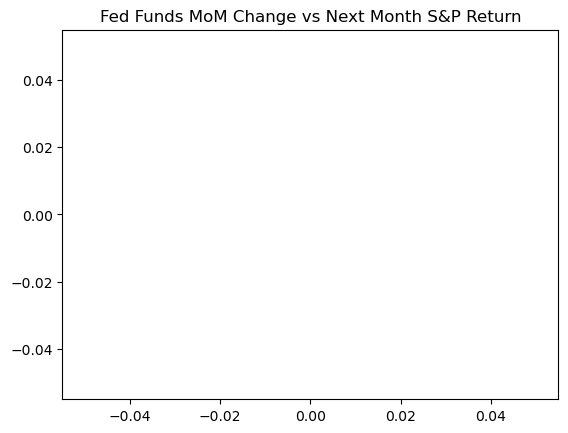

In [51]:
sns.scatterplot(
    data=sp500_macro, x="ff_mom", y="ret_1m_next"
)
plt.title("Fed Funds MoM Change vs Next Month S&P Return")
plt.show()
